In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_prediction import Replicator
from pneumococcus_data import data_observation
from subsystem import alpha_extract

In [2]:
Iran, Denmark, Brazil, Nepal, Mozambique = data_observation()

country = np.array([Iran, Nepal, Brazil, Denmark, Mozambique], dtype = object)
mu_list = np.array([0.93, 3.95, 9.85, 10.23, 16.8])

In [3]:
#function compute Lambda matrix with a strain list given
def compute_lambda(strain_list, big_alpha):
    #extract data for each country
    strain_number = len(strain_list)
    
    #initial values
    u0 = (1/strain_number)*np.ones(strain_number)
    
    #extract alpha matrix from big alpha
    alpha_matrix = alpha_extract(strain_list, big_alpha)
    
    #compute fitness matrix
    lambd = np.zeros((strain_number, strain_number))
    for i in range (0, strain_number):
        for j in range (0, strain_number):
            lambd[i][j] = mu*(alpha_matrix[j][i] - alpha_matrix[i][j]) + alpha_matrix[j][i] - alpha_matrix[j][j]
            
    return lambd

In [4]:
#function compute lambda_i^j ^ lambda_j^i list and probability of exclusion
def compute_LL(lambd):
    LL21,LL12 = [],[]
    size = len(lambd[0])
    count_e = 0
    count_co = 0
    count_bi = 0
    
    for i in range (0, size):
        for j in range (0, size):
            l21 = lambd[i,j]
            l12 = lambd[j,i]
            if l12*l21 < 0:
                count_e +=1
            if l12 < 0 and l21 < 0:
                count_bi +=1
            
            if l12 > 0 and l21 > 0:
                count_co +=1
                
            LL12.append(l12)
            LL21.append(l21)
            
    pop = size**2
    p_e = np.around(count_e/pop*100,1)
    p_bi = np.around(count_bi/pop*100,1)
    p_co = np.around(count_co/pop*100,1)
    
    return LL21, LL12, p_e, p_bi, p_co

In [5]:
#function paint four quartures
big_alpha_Jan = np.loadtxt(open("big_alpha_Jan.txt","rb"), delimiter = ",", skiprows = 0)
big_alpha_May = np.loadtxt(open("big_alpha_May.txt","rb"), delimiter = ",", skiprows = 0)
big_alpha = [big_alpha_Jan, big_alpha_May]

colors = ['gainsboro', 'salmon', 'grey', 'cornflowerblue']

def paint(length, ax = None):
    X = np.linspace(-length, length, 20*length)
    Y = np.linspace(-length, length, 20*length)
    x, y =  np.meshgrid(X, Y)
    
    pos1 = x > 0
    pos2 = y > 0
    neg1 = x < 0
    neg2 = y < 0

    coex = 0.5*pos1*pos2
    bista = 2.5*neg1*neg2
    s2 =   1.5*pos2*neg1
    s1 = -0.5*pos1*neg2
    scen = coex + s1 + s2 + bista
    
    if ax is None : 
        ax = plt.gca()
        
    ax.contourf(x, y, scen, levels = [-1, 0, 1, 2, 3], colors = colors)
    return ax
    #proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in ax2.collections]
    #ax2.legend(proxy, ["strain 1 wins", "coexistence", "strain 2 wins", "bistability"])

Order 1
Iran
69.8 7.6 19.3
Nepal
88.2 4.5 5.8
Brazil
91.7 2.4 2.1
Denmark
94.0 1.7 1.3
Mozambique
95.0 1.3 1.5
Order 2
Iran
41.8 2.9 52.0
Nepal
0.0 0.0 98.6
Brazil
17.5 0.0 78.7
Denmark
21.1 0.0 75.8
Mozambique
22.3 0.0 75.5


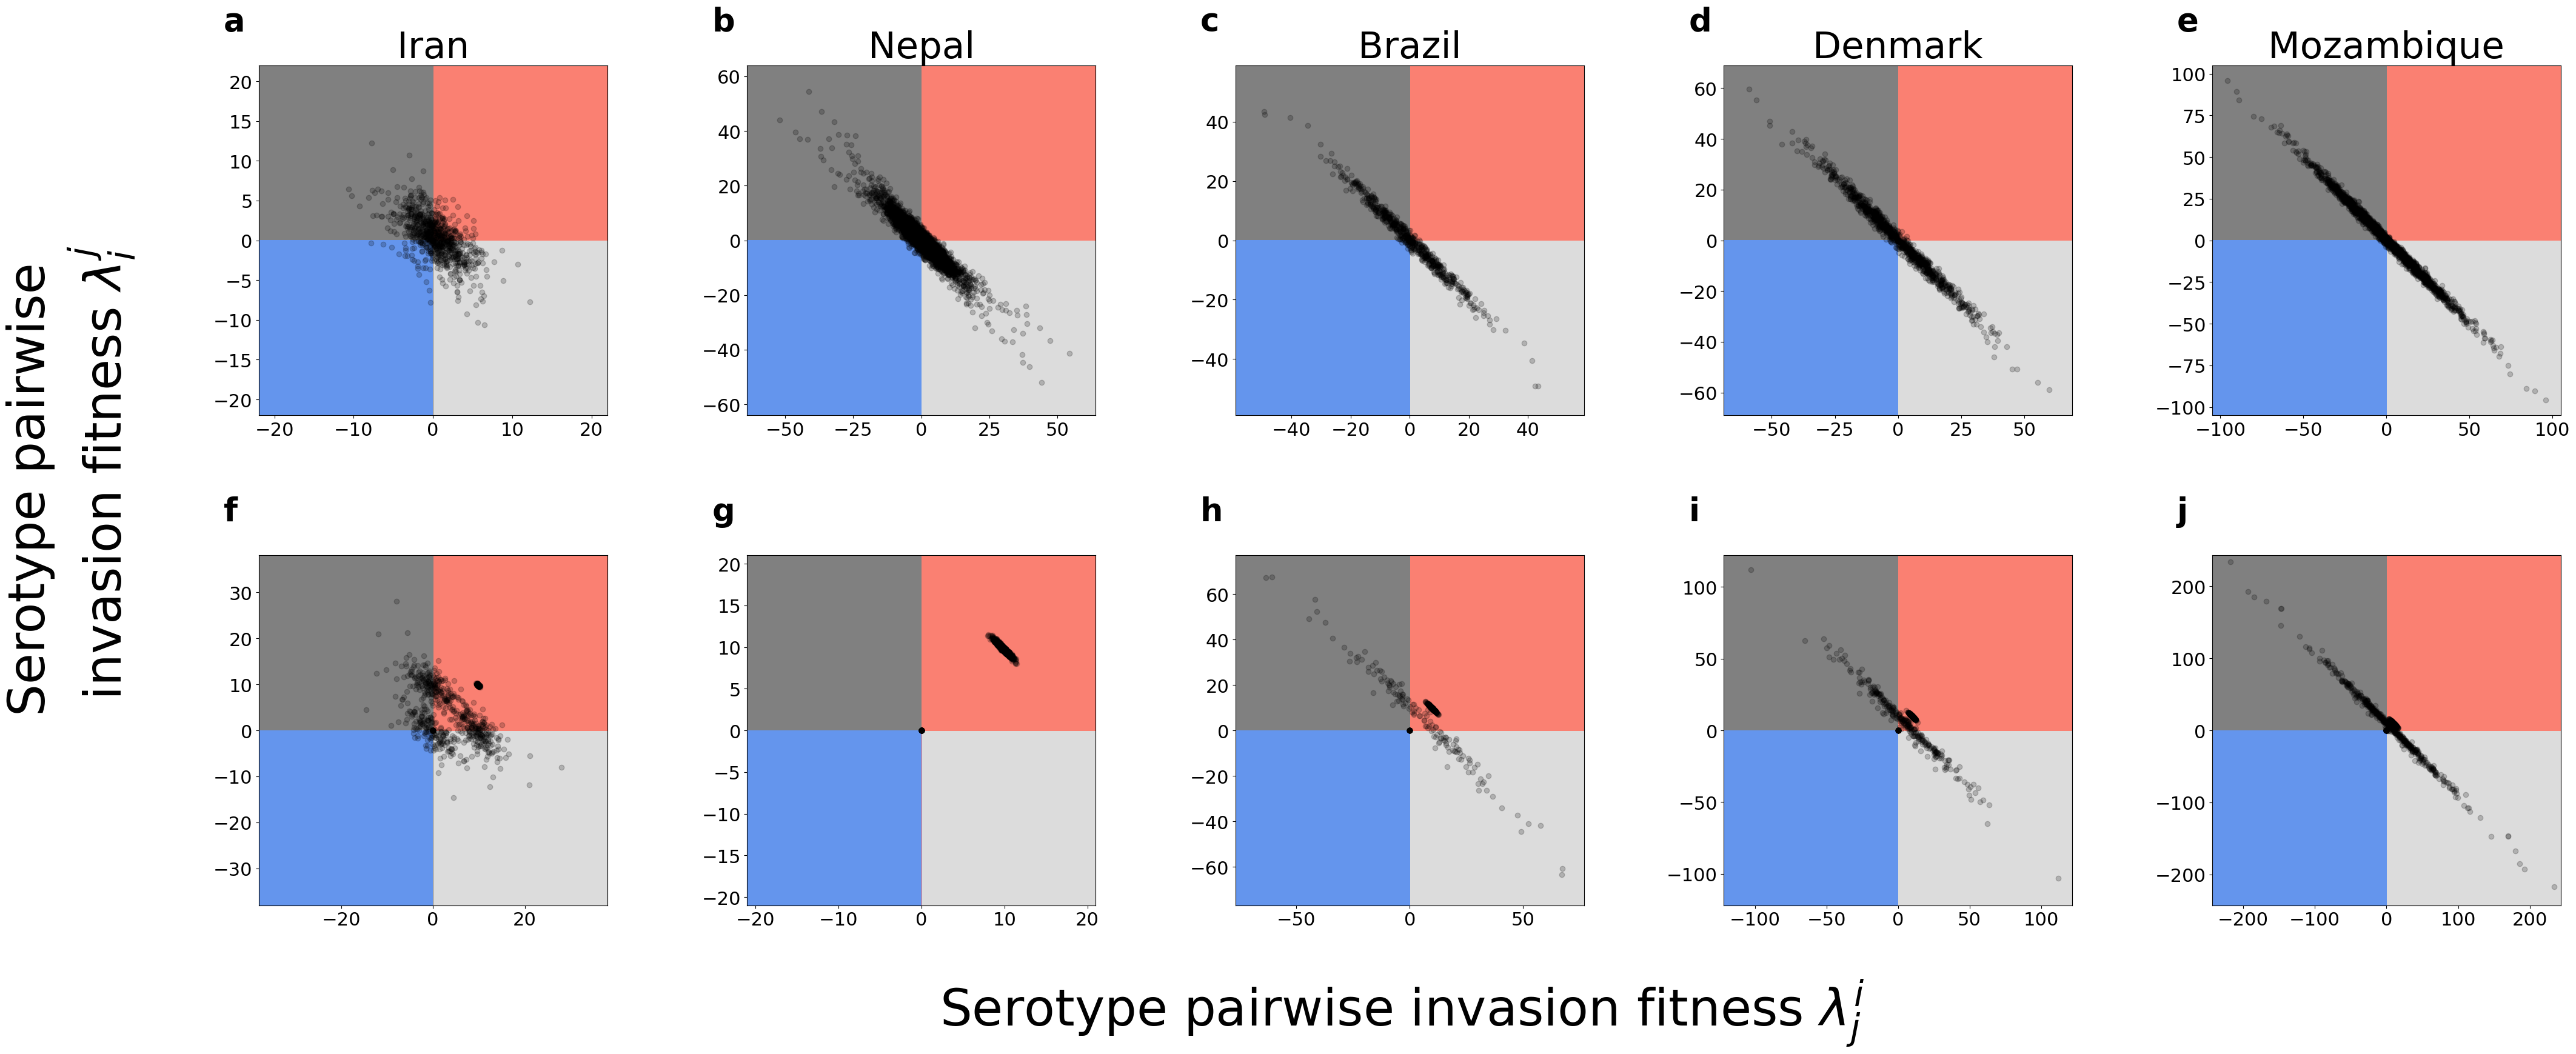

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(49, 18))
fig.subplots_adjust(wspace = 0.4, hspace = 0.4)

name_country = np.array(['Iran', 'Nepal', 'Brazil', 'Denmark', 'Mozambique'])
abc = np.array([['a', 'b', 'c', 'd', 'e'], ['f', 'g', 'h', 'i', 'j']])

for i in range (0, 2):
    print(f'Order {i + 1}')
    for j in range (0, 5):
        print(f'{name_country[j]}')
        #extract each country' strain and compute LL12 & LL21
        strain_list = np.array(country[j].strain)
        mu = mu_list[j]
        lambd = compute_lambda(strain_list, big_alpha[i])

        LL21, LL12, p_e, p_bi, p_co = compute_LL(lambd)
        print(p_e, p_bi, p_co)
        
        mini = lambd.min()
        maxi = lambd.max()
        length = int(np.max([-mini, maxi]) + 10)
        paint(length, ax[i,j])
    
        ax[i,j].scatter(LL21, LL12, color = 'k', alpha = .2)
        ax[i,j].text(-.1, 1.1, f'{abc[i,j]}', transform = ax[i,j].transAxes, fontsize = 38, weight='bold')

        ax[i,j].tick_params(axis = 'x', which='major', labelsize = 22)
        ax[i,j].tick_params(axis = 'y', which='major', labelsize = 22)


for j in range (0, 5):
    ax[0,j].set_title(f'{name_country[j]}', fontsize = 44)


fig.text(0.51, 0, 'Serotype pairwise invasion fitness $\\lambda^i_j$', fontsize = 60, ha='center')
fig.text(0.04, 0.5, 'Serotype pairwise \n invasion fitness $\\lambda^j_i$', fontsize = 60, va='center', rotation='vertical')
plt.show()

In [ ]:
fig.savefig('outcomes_quarters.png', dpi = 300, bbox_inches='tight')